In [1]:
from IPython.display import display

from sympy import *
init_printing()

from monom import *

In [2]:
t, x, tau, h, s0, s1, s = symbols(r't, x, tau, h, sigma_0, sigma_1, sigma', real=True)
f1, f2 = (f(t, x) for f in symbols('\phi_1, \phi_2', cls=Function))

In [3]:
pda_f, pda_v = (f1, f2), (t, x)
pda_n, pda_clp = 5, 3
pda_p = Rational(0, 1), Rational(0, 1), Rational(0, 1)

In [4]:
Monom.variables = 1 + len(pda_v)
Monom.cmp = Monom.TOPdeglex
# Monom.cmp = Monom.TOPlex
Monom.zero = Monom(0 for v in range(Monom.variables))
pda_fun = dict(zip(pda_f,\
             (Monom(0 if v else i for v in range(Monom.variables))\
              for i in range(1, Monom.variables))))
pda_var = dict(zip(pda_v,\
             (Monom(0 if v != i else 1 for v in range(Monom.variables))\
              for i in range(1, Monom.variables))))

In [5]:
def T(f, i1, j1):
    return sum(sum(\
        diff(f, t, i, x, j)*(tau*(i1+pda_p[0]))**i \
                             *(h*(j1+pda_p[1]))**j/\
                 (factorial(i)*factorial(j))\
        for i in range(pda_n-j))\
        for j in range(pda_n))

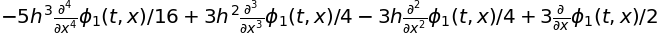

In [6]:
expand((T(f1, 0, 1)-T(f1, 0, -2))/(2*h))

In [7]:
def clip(f):
    f = f.expand()
    return [f.coeff(tau, 0).coeff(h, 0),\
            f.coeff(h, 0).coeff(tau, 2),\
            f.coeff(tau, 0).coeff(h, 2)]

def df2m(a):
    assert a.func == Derivative
    m = pda_fun[a.args[0]]
    for xi in a.args[1:]:
        if isinstance(xi, Symbol):
            m = m*pda_var[xi]
        else:
            m = m*pda_var[xi[0]]**xi[1]
    return m

def m2df(m):
    r = pda_f[m[0]-1]
    for i in range(1, len(m)):
        r = r.diff(pda_v[i-1], m[i])
    return r

def findDiv(a, d):
    r = None
    def find(a, r):
        if a.args:
            if a.func == Derivative and a.args[0] in pda_fun:
                m = df2m(a)
                if m.divisible(d) and (not r or m.cmp(r) > 0):
                    r = m
            else:
                for s in a.args:
                    r = find(s, r)
        return r
    return find(a, r)

def reduction(f1, f2, m, c, shift):
    assert shift < pda_clp
    r = [f1[i] for i in range(shift)]
    if not m:
        for i in range(shift, pda_clp):
            r.append(expand(f1[i] - f2[i-shift]*c))
    else:
        for i in range(shift, pda_clp):
            r.append(expand(f1[i] - f2[i-shift].diff(*m)*c))
    return r

def NF(f, df, G, head=False, trace=False):
    assert len(df) == len(G)
#     print(df2m(df[0]))
    ms = [df2m(d) for d in df]
    for i in range(0 if head else 1, pda_clp):
        t = 0
        if f[i]:
            while True:
                r = None
                for l in range(len(ms)):
                    r = findDiv(f[i], ms[l])
                    if r:
                        break
                if not r: 
                    break
                c, deg, m = 0, 7, m2df(r)
                while c == 0:
                    c = f[i].coeff(m, deg)
                    deg -= 1
                    assert deg >= 0
#                 print(c, m, deg+1)
                if deg:
                    c *= m**deg
                m = r/ms[l]
                d = []
                for k in range(len(pda_v)):
                    if m[k+1] > 0:
                        d.append(pda_v[k])
                        if m[k+1] > 1:
                            d.append(m[k+1])
                if trace:
                    print(">"*12)
                    eq = Symbol("eq%d" % (l+1), real=True)
                    if d:
                        display(Derivative(*tuple([eq] + d))*c*h**i)
                    else:
                        display(eq*c*h**i)
                f = reduction(f, G[l], tuple(d), c/G[l][0].coeff(df[l]), i)
                if trace:
                    print("res =")
                    display(f)
                    print("<"*12)
                t += 1
#                 if t > 6: break
    return f

def p2Latex(p):
    def m2L(m):
        f = F2p[m[0] - 1]
        r = []
        for v in range(1, Monom.variables):
            for i in range(m[v]):
                r.append(V2p[v-1])
        if not r:
            return Symbol(f, real=True)
        else:
            return Symbol(f + "_{%s}" % "".join(r), real=True)
    return sum(tau**Rang[i][0]*h**Rang[i][1]*sum(m2L(m)*c for m, c in p[i]) for i in range(len(p)) if p[i])

def p2Latex(a):
    r = None
    def find(a):
        if not a.args:
            return a
        elif a in pda_fun:
            return Symbol(str(a.func), real=True)
        else:
            if a.func == Derivative and a.args[0] in pda_fun:
                m, r = df2m(a), [str(a.args[0].func)[-1]]
                for v in range(1, Monom.variables):
                    for i in range(m[v]):
                        r.append(str(pda_v[v-1]))
                return Symbol(str(a.args[0].func)[:-2] + "_{%s}" % "".join(r), real=True)
            else:
                return a.func(*(find(s) for s in a.args))
    return find(a)

def prn(a):
    display(p2Latex(a[0]))
    print("tau^2 =>")
    display(p2Latex(a[1]))
    print("h^2 =>")
    display(p2Latex(a[2]))

In [9]:
def Dt(a):
    return (T(a, 1, 0) - T(a, 0, 0))/(tau)
def Dx(a):
    return (T(a, 0, 1) - T(a, 0, -1))/(2*h)
def Dxxx(a):
    return (T(a, 0, 2) - 2*T(a, 0, 1) + 2*T(a, 0, -1) - T(a, 0, -2))/(2*h**3)
def It(a):
    return (T(a, 1, 0) + T(a, 0, 0))/2


In [18]:
F1 = clip(Dt(f1) + It(3*s0*Dx(f1**2) + 2*s1*Dx(f1**3) + Dxxx(f1) + f1 - f2))
prn(F1)

tau^2 =>


h^2 =>


In [19]:
F2 = clip(Dt(f2) + It(3*s0*Dx(f2**2) + 2*s1*Dx(f2**3) + Dxxx(f2) + f2 - f1 + s*f2))
prn(F2)

tau^2 =>


h^2 =>


In [20]:
F1pda = NF(F1, [f1.diff(x, 3), f2.diff(x, 3)], [F1, F2], head=False)
prn(F1pda)
print(p2Latex(F1pda[2]))

tau^2 =>


h^2 =>


-6*\phi_1**4*\phi_{1x}*sigma_1**2 - 12*\phi_1**3*\phi_{1x}*sigma_0*sigma_1 - \phi_1**3*sigma_1 + \phi_1**2*\phi_2*sigma_1 - \phi_1**2*\phi_{1t}*sigma_1 - 6*\phi_1**2*\phi_{1x}*sigma_0**2 - \phi_1**2*sigma_0 + \phi_1*\phi_2*sigma_0 - \phi_1*\phi_{1t}*sigma_0 + 6*\phi_1*\phi_{1xx}*\phi_{1x}*sigma_1 + \phi_{1ttttt}/48 + 3*\phi_{1xx}*\phi_{1x}*sigma_0 + 2*\phi_{1x}**3*sigma_1


In [21]:
F2pda = NF(F2, [f1.diff(x, 3), f2.diff(x, 3)], [F1, F2], head=False)
prn(F2pda)
print(p2Latex(F2pda[2]))

tau^2 =>


h^2 =>


\phi_1*\phi_2**2*sigma_1 + \phi_1*\phi_2*sigma_0 - 6*\phi_2**4*\phi_{2x}*sigma_1**2 - 12*\phi_2**3*\phi_{2x}*sigma_0*sigma_1 - \phi_2**3*sigma*sigma_1 - \phi_2**3*sigma_1 - \phi_2**2*\phi_{2t}*sigma_1 - 6*\phi_2**2*\phi_{2x}*sigma_0**2 - \phi_2**2*sigma*sigma_0 - \phi_2**2*sigma_0 - \phi_2*\phi_{2t}*sigma_0 + 6*\phi_2*\phi_{2xx}*\phi_{2x}*sigma_1 + \phi_{2ttttt}/48 + 3*\phi_{2xx}*\phi_{2x}*sigma_0 + 2*\phi_{2x}**3*sigma_1


In [13]:
D, k = symbols('D, k', real=True)

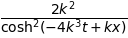

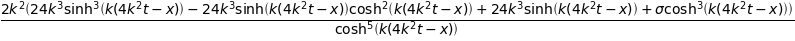

In [14]:
ex3 = 2*k**2/cosh(k*x - 4*k**3*t)**2
display(ex3)
display(F2pda[0].subs({s0: 1, s1: 0})\
  .subs({f1: ex3, f2: ex3}).doit().simplify())

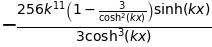

-256*k**11*(1 - 3/cosh(k*x)**2)*sinh(k*x)/(3*cosh(k*x)**3)


In [15]:
display(F2pda[1].subs({s0: 1, s1: 0})\
  .subs({f1: ex3, f2: ex3}).subs({t: 0}).doit().simplify())
print(F2pda[1].subs({s0: 1, s1: 0})\
  .subs({f1: ex3, f2: ex3}).subs({t: 0}).doit().simplify())

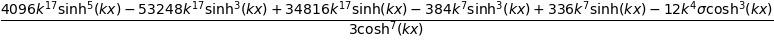

(4096*k**17*sinh(k*x)**5 - 53248*k**17*sinh(k*x)**3 + 34816*k**17*sinh(k*x) - 384*k**7*sinh(k*x)**3 + 336*k**7*sinh(k*x) - 12*k**4*sigma*cosh(k*x)**3)/(3*cosh(k*x)**7)


In [16]:
display(F2pda[2].subs({s0: 1, s1: 0})\
  .subs({f1: ex3, f2: ex3}).subs({t: 0}).doit().simplify())
print(F2pda[2].subs({s0: 1, s1: 0})\
  .subs({f1: ex3, f2: ex3}).subs({t: 0}).doit().simplify())

In [17]:
ex1 = s0/(2*s1) + k/sqrt(s1)*tanh(k*x - k*(-2*k**2+3*s0**2/(2*s1))*t)
display(ex1)
display(F2pda[0].subs({s1: -s1})\
  .subs({f1: ex1, f2: ex1}).doit().simplify())

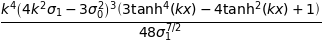

k**4*(4*k**2*sigma_1 - 3*sigma_0**2)**3*(3*tanh(k*x)**4 - 4*tanh(k*x)**2 + 1)/(48*sigma_1**(7/2))


In [18]:
display(F2pda[1].subs({s1: -s1})\
  .subs({f1: ex1, f2: ex1}).subs({t: 0}).doit().simplify())
print(F2pda[1].subs({s1: -s1})\
  .subs({f1: ex1, f2: ex1}).subs({t: 0}).doit().simplify())

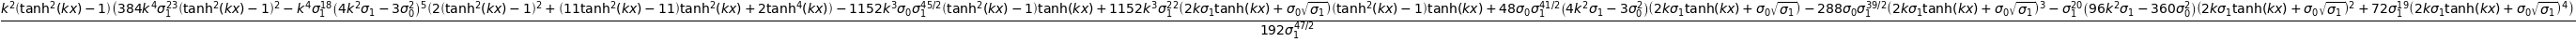

k**2*(tanh(k*x)**2 - 1)*(384*k**4*sigma_1**23*(tanh(k*x)**2 - 1)**2 - k**4*sigma_1**18*(4*k**2*sigma_1 - 3*sigma_0**2)**5*(2*(tanh(k*x)**2 - 1)**2 + (11*tanh(k*x)**2 - 11)*tanh(k*x)**2 + 2*tanh(k*x)**4) - 1152*k**3*sigma_0*sigma_1**(45/2)*(tanh(k*x)**2 - 1)*tanh(k*x) + 1152*k**3*sigma_1**22*(2*k*sigma_1*tanh(k*x) + sigma_0*sqrt(sigma_1))*(tanh(k*x)**2 - 1)*tanh(k*x) + 48*sigma_0*sigma_1**(41/2)*(4*k**2*sigma_1 - 3*sigma_0**2)*(2*k*sigma_1*tanh(k*x) + sigma_0*sqrt(sigma_1)) - 288*sigma_0*sigma_1**(39/2)*(2*k*sigma_1*tanh(k*x) + sigma_0*sqrt(sigma_1))**3 - sigma_1**20*(96*k**2*sigma_1 - 360*sigma_0**2)*(2*k*sigma_1*tanh(k*x) + sigma_0*sqrt(sigma_1))**2 + 72*sigma_1**19*(2*k*sigma_1*tanh(k*x) + sigma_0*sqrt(sigma_1))**4)/(192*sigma_1**(47/2))


In [19]:
display(F1pda[2].subs({s1: -s1})\
  .subs({f1: ex1, f2: ex1}).subs({t: 0}).doit().simplify())
print(F1pda[2].subs({s1: -s1})\
  .subs({f1: ex1, f2: ex1}).subs({t: 0}).doit().simplify())

In [20]:
F = (-2*D*s1 + s0)
ex2 = D + k**2/(F + sqrt(F**2 - k**2*s1)*cosh(k*(x - (6*D*(-D*s1 + s0) +  k**2)*t)))
display(ex1)
display(F1pda[0].subs({s1: -s1})\
  .subs({f1: ex2, f2: ex2}).doit().simplify())

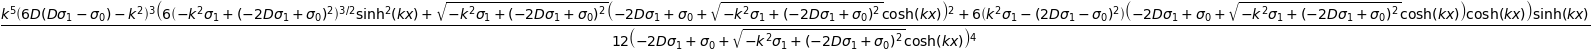

k**5*(6*D*(D*sigma_1 - sigma_0) - k**2)**3*(6*(-k**2*sigma_1 + (-2*D*sigma_1 + sigma_0)**2)**(3/2)*sinh(k*x)**2 + sqrt(-k**2*sigma_1 + (-2*D*sigma_1 + sigma_0)**2)*(-2*D*sigma_1 + sigma_0 + sqrt(-k**2*sigma_1 + (-2*D*sigma_1 + sigma_0)**2)*cosh(k*x))**2 + 6*(k**2*sigma_1 - (2*D*sigma_1 - sigma_0)**2)*(-2*D*sigma_1 + sigma_0 + sqrt(-k**2*sigma_1 + (-2*D*sigma_1 + sigma_0)**2)*cosh(k*x))*cosh(k*x))*sinh(k*x)/(12*(-2*D*sigma_1 + sigma_0 + sqrt(-k**2*sigma_1 + (-2*D*sigma_1 + sigma_0)**2)*cosh(k*x))**4)


In [21]:
display(F1pda[1].subs({s1: -s1})\
  .subs({f1: ex2, f2: ex2}).subs({t: 0}).doit().simplify())
print(F1pda[1].subs({s1: -s1})\
  .subs({f1: ex2, f2: ex2}).subs({t: 0}).doit().simplify())

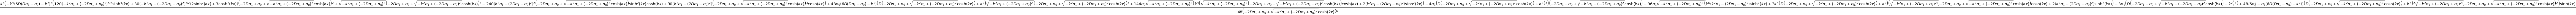

k**3*(-k**4*(6*D*(D*sigma_1 - sigma_0) - k**2)**5*(120*(-k**2*sigma_1 + (-2*D*sigma_1 + sigma_0)**2)**(5/2)*sinh(k*x)**4 + 30*(-k**2*sigma_1 + (-2*D*sigma_1 + sigma_0)**2)**(3/2)*(2*sinh(k*x)**2 + 3*cosh(k*x)**2)*(-2*D*sigma_1 + sigma_0 + sqrt(-k**2*sigma_1 + (-2*D*sigma_1 + sigma_0)**2)*cosh(k*x))**2 + sqrt(-k**2*sigma_1 + (-2*D*sigma_1 + sigma_0)**2)*(-2*D*sigma_1 + sigma_0 + sqrt(-k**2*sigma_1 + (-2*D*sigma_1 + sigma_0)**2)*cosh(k*x))**4 - 240*(k**2*sigma_1 - (2*D*sigma_1 - sigma_0)**2)**2*(-2*D*sigma_1 + sigma_0 + sqrt(-k**2*sigma_1 + (-2*D*sigma_1 + sigma_0)**2)*cosh(k*x))*sinh(k*x)**2*cosh(k*x) + 30*(k**2*sigma_1 - (2*D*sigma_1 - sigma_0)**2)*(-2*D*sigma_1 + sigma_0 + sqrt(-k**2*sigma_1 + (-2*D*sigma_1 + sigma_0)**2)*cosh(k*x))**3*cosh(k*x)) + 48*sigma_0*(6*D*(D*sigma_1 - sigma_0) - k**2)*(D*(-2*D*sigma_1 + sigma_0 + sqrt(-k**2*sigma_1 + (-2*D*sigma_1 + sigma_0)**2)*cosh(k*x)) + k**2)*sqrt(-k**2*sigma_1 + (-2*D*sigma_1 + sigma_0)**2)*(-2*D*sigma_1 + sigma_0 + sqrt(-k**2*sigma_1 +

In [22]:
display(F1pda[2].subs({s1: -s1})\
  .subs({f1: ex2, f2: ex2}).subs({t: 0}).doit().simplify())
print(F1pda[2].subs({s1: -s1})\
  .subs({f1: ex2, f2: ex2}).subs({t: 0}).doit().simplify())

In [23]:
from pylab import *

In [24]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 30., 100
x = array(linspace(-L*.5, L*.5, N), dtype=float64)

In [25]:
def err1tau(x, k):
    return -256*k**11*(1 - 3/cosh(k*x)**2)*sinh(k*x)/(3*cosh(k*x)**3)
def err1h(x, k):
    return 16*k**7*(256*k**10*sinh(k*x)**4 - 3328*k**10*sinh(k*x)**2 \
                    + 2176*k**10 - 24*sinh(k*x)**2 + 21)*sinh(k*x)/(3*cosh(k*x)**7)

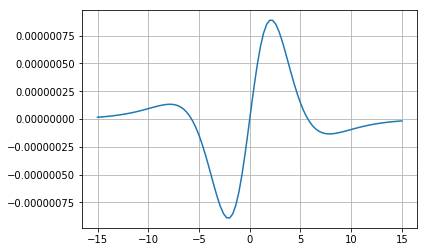

In [26]:
plot(x, err1tau(x, 0.2), label="k=0.2")
grid()

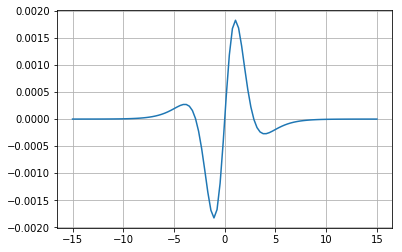

In [27]:
plot(x, err1tau(x, 0.4), label="k=0.4")
grid()

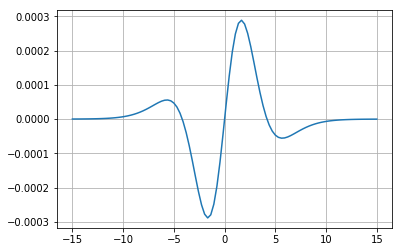

In [28]:
plot(x, err1h(x, 0.2), label="k=0.2")
grid()

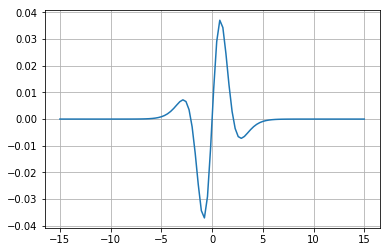

In [29]:
plot(x, err1h(x, 0.4), label="k=0.4")
grid()